<a href="https://colab.research.google.com/github/konan-91/OcularClassification/blob/master/notebooks/1_data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Generating Topoplots from Blinks

Our first step is to transform the dataset of ocular & non-ocular EEG data into spectograms (image files) that we can use to train the model.

In [ ]:
# Mounting to Google Drive is necessary as the dataset is large!
# If you are running the notebook locally or are manually uploading the file to
# your workspace, you can skip this step.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install mne -q
!pip install pymatreader -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 44.9 MB/s eta 0:00:00


In [3]:
import mne
import pymatreader
import matplotlib.pyplot as plt
import numpy as np
import os

##Loading the data

Note: if you are running this notebook yourself, please ensure the zipped osf dataset is present at the root of your working directory. In Colab, this is /content.

In [4]:
# If importing file from drive
extract_path = "/content/osfstorage"
if not os.path.exists(extract_path):
    os.mkdir(extract_path)

!unzip -q /content/drive/MyDrive/diss/osfstorage-archive.zip -d /content/osfstorage-archive

unzip:  cannot find or open /content/drive/MyDrive/diss/osfstorage-archive.zip, /content/drive/MyDrive/diss/osfstorage-archive.zip.zip or /content/drive/MyDrive/diss/osfstorage-archive.zip.ZIP.


In [5]:
# If uploading file to workspace
extract_path = "/content/osfstorage"
if not os.path.exists(extract_path):
    os.mkdir(extract_path)

!unzip -q /content/osfstorage-archive.zip
!rm /content/osfstorage-archive.zip

In [6]:
def load_data(folderpath, data):
    for filename in os.listdir(folderpath):
        if filename.endswith(".set"):
            filepath = os.path.join(folderpath, filename)
            epochs = mne.read_epochs_eeglab(filepath) # The dataset we use comes pre-epoched
            data.append(epochs)

In [ ]:
mne.set_log_level()
path = "/content/osfstorage-archive"
participantsData = [] # List of participants, who are objects containing (many) epochs

for study in os.listdir(path):
    study_path = os.path.join(path, study)
    if os.path.isdir(study_path):
        load_data(study_path, participantsData)

###Understanding the Dataset

Participants were asked to rest, blink, and make horizontal and vertical eye movements. As such, the dataset contains labelled and timestamped data of when each event occured. Labelled data is ideal for training classification models, as we can teach it to accurately disciminate between each event.

The OSF training dataset is split into 5 studies. Each study contains EEGLAB objects which represent each participant in the study. Each object is a collection of epochs, containing rest events, blinks, or saccades. Each epoch may contain anywhere from 6-20 events of *only* one of the prior listed event types. In order to maximise the amount of training data, we need to split the data so that each individual event has it's own epoch (ex. each blink is its own epoch, rather than an epoch containing 6+ blinks).

In [9]:
blinks_data = [participant['4'] for participant in participantsData]

# For the negative data, we'll use a mix of the other event types: rest, and horizontal and vertical saccades
h_saccades_data = [participant['2'] for participant in participantsData]
v_saccades_data = [participant['3'] for participant in participantsData]
rest_data = [participant['1'] for participant in participantsData]

Below is a graph of an blink epoch containing 7 individual blinks, alongside a graph of the trigger channel. Data will be re-epoched at the start of each trigger, ending at the beginning of the next (or when the epoch ends).

{'4/blink/blink/blink/blink/blink/blink': 5}
{'4/blink/blink/blink/blink/blink/blink/blink': 4, '4/blink/blink/blink/blink/blink/blink': 8}
{'4/blink/blink/blink/blink/blink/blink': 5, '4/blink/blink/blink/blink/blink/blink/blink': 9}
{'4/blink/blink/blink/blink/blink/blink': 3, '4/blink/blink/blink/blink/blink/blink/blink': 6}
{'4/blink/blink/blink/blink/blink/blink': 1}
5
Using matplotlib as 2D backend.


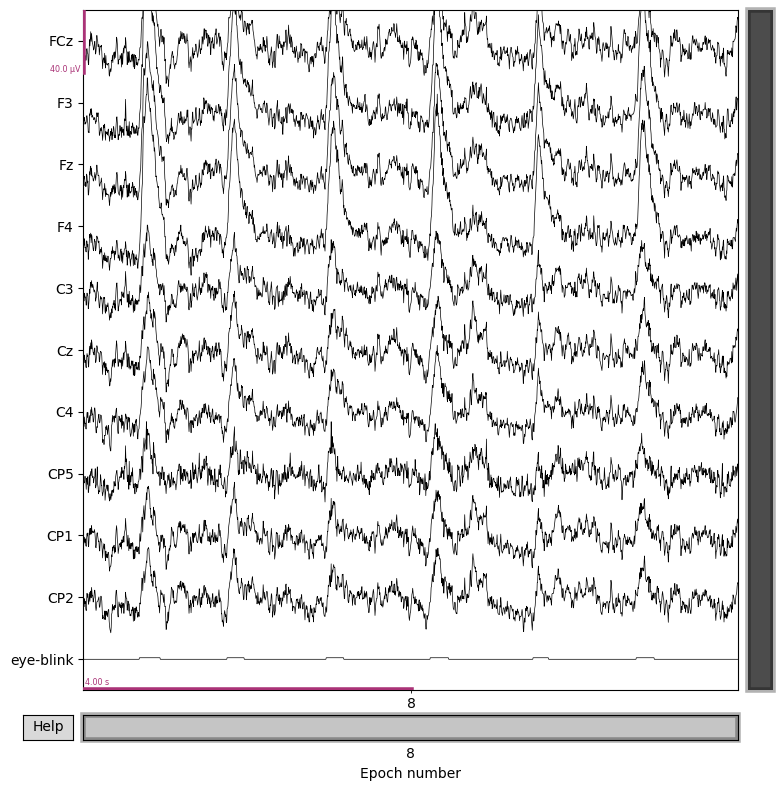

In [10]:
for event in blinks_data:
    print(event.event_id)
print(len(blinks_data))

blinks_data[0][0].plot(picks=['eye-blink', 'C3', 'C4', 'FCz', 'F3', 'Fz', 'F4', 'Cz', 'C4', 'CP5', 'CP1', 'CP2']);

## Converting EEGLABS to MNEPython
Function which takes a list of epochs, and divides each epoch based on a trigger channel. Also making folder for all the converted things to go in.

In [11]:
print(type(blinks_data))
print(type(blinks_data[0]))

os.makedirs("converted_epochs", exist_ok=True)

<class 'list'>
<class 'mne.io.eeglab.eeglab.EpochsEEGLAB'>


In [12]:
def eeglabs_to_mne(eeglabs_epochs, output_folder):
    epoch_no = 0
    os.makedirs(f"converted_epochs/{output_folder}", exist_ok=True)

    for epoch in eeglabs_epochs:
        # Initialize event dictionary and event list
        event_dict = {}
        event_list = []

        # Extract unique event names from EEGLAB
        for i, event_desc in enumerate(epoch.events[:, -1]):
            # Convert to string and assign ID
            event_label = str(epoch.event_id.get(event_desc, event_desc))
            if event_label not in event_dict:
                event_dict[event_label] = len(event_dict) + 1  # Ensure event_id values are integers

            event_list.append([epoch.events[i, 0], 0, event_dict[event_label]])

        event_array = np.array(event_list, dtype=int)  # Ensure integer type for MNE compatibility

        # Update the EEGLAB epochs object with new events and event_id
        epoch.events = event_array
        epoch.event_id = event_dict  # Ensure keys are strings and values are integers

        # Save the converted epochs
        save_path = os.path.join(f"converted_epochs/{output_folder}", f"{epoch_no}-epo.fif")
        epoch.save(save_path, overwrite=True)
        epoch_no += 1

In [13]:
eeglabs_to_mne(blinks_data, "blinks")
eeglabs_to_mne(h_saccades_data, "h_saccades")
eeglabs_to_mne(v_saccades_data, "v_saccades")
eeglabs_to_mne(rest_data, "rest")

Now the MNE epochs have been saved as .fif files, we can read them back into memory is MNE epochs objects.

In [ ]:
converted_blinks = []
converted_h_saccades = []
converted_v_saccades = []
converted_rest = []

subfolders = {
    "blinks": converted_blinks,
    "h_saccades": converted_h_saccades,
    "v_saccades": converted_v_saccades,
    "rest": converted_rest,
}

base_path = "converted_epochs"
for subfolder, storage_list in subfolders.items():
    folder_path = os.path.join(base_path, subfolder)
    if os.path.exists(folder_path):
        for filename in os.listdir(folder_path):
            if filename.endswith(".fif"):
                filepath = os.path.join(folder_path, filename)
                storage_list.append(mne.read_epochs(filepath))


In [15]:
converted_lists = [converted_blinks, converted_h_saccades, converted_v_saccades, converted_rest]

for epoch_list in converted_lists:
    print(type(epoch_list[0]))
    print(f"objects: {len(epoch_list)}")

    total_epochs = 0
    for epoch in epoch_list:
        total_epochs += len(epoch)
    print(f"total epochs: {total_epochs}\n")

<class 'mne.epochs.EpochsFIF'>
objects: 5
total epochs: 53

<class 'mne.epochs.EpochsFIF'>
objects: 5
total epochs: 54

<class 'mne.epochs.EpochsFIF'>
objects: 5
total epochs: 58

<class 'mne.epochs.EpochsFIF'>
objects: 5
total epochs: 88



## Re-epoching around trigger channels
Use MNE object and re-epoch it based on the trigger channel - this allows us to get cleaner, smaller time segments where each event occurs (ex. a time segment of several blinks is split into smaller segments containing one blink each!).

This is important as the plots generated will ultimately average all of the activity across a given span of time into a single plot. This is only helpful if each epoch contains the activity from only one event.

In [16]:
from typing import List

def split_epochs_by_blinks(epochs_list: List[mne.Epochs]) -> List[mne.Epochs]:
    split_epochs_list = []

    for epochs in epochs_list:
        # Get the 'eye-blink' channel index
        blink_ch_idx = epochs.ch_names.index('eye-blink')

        # Get samplig frequency
        sfreq = epochs.info['sfreq']

        # Get all epoch data
        data = epochs.get_data()

        # New data list to store single-blink epochs
        new_data = []
        new_events = []

        # Time window for new epochs (in samples)
        tmin_samples = int(-0.2 * sfreq)  # 200ms before
        tmax_samples = int(0.5 * sfreq)   # 500ms after
        window_length = tmax_samples - tmin_samples

        # Keep track of used time points
        used_times = set()

        for i in range(len(epochs)):
            # Get the trigger channel data for this epoch
            trigger_data = data[i, blink_ch_idx, :]

            # Find all timestamps where blinks start (trigger value changes from 0 to 1)
            blink_starts = np.where(np.diff(trigger_data) > 0)[0]

            for blink_start in blink_starts:
                # Calculate absolute time point
                abs_time = epochs.events[i, 0] + blink_start

                # If this timestamp is already used, increment until we find an unused one
                while abs_time in used_times:
                    abs_time += 1

                used_times.add(abs_time)

                # Calculate window indices
                start_idx = blink_start + tmin_samples
                end_idx = blink_start + tmax_samples

                # Check if window is within epoch bounds
                if start_idx >= 0 and end_idx < data.shape[2]:
                    # Extract data window around blink
                    blink_data = data[i, :, start_idx:end_idx]
                    new_data.append(blink_data)

                    # Create an event for this blink
                    new_events.append([abs_time, 0, epochs.events[i, 2]])

        if not new_data:
            print(f"No valid blink events found in epoch set")
            continue

        # Convert lists to arrays
        new_data = np.array(new_data)
        new_events = np.array(new_events)

        # Create new Epochs object
        new_epochs = mne.EpochsArray(
            new_data,
            epochs.info.copy(),
            new_events,
            tmin=-0.2,
            event_id={str(id): id for id in np.unique(new_events[:, 2])}, #event_id=epochs.event_id, # I think this is broken?
            verbose=False
        )

        split_epochs_list.append(new_epochs)

    return split_epochs_list

In [17]:
split_epochs = split_epochs_by_blinks(converted_epochs)

# Printing etc
print(type(split_epochs[0]))
print(f"objects (participants): {len(split_epochs)}")
total_epochs = 0
for epoch in split_epochs:
    total_epochs += len(epoch)
print(f"total epochs: {total_epochs}")

<class 'mne.epochs.EpochsArray'>
objects (participants): 5
total epochs: 319


Plot of all epochs from participant 1 before splitting...

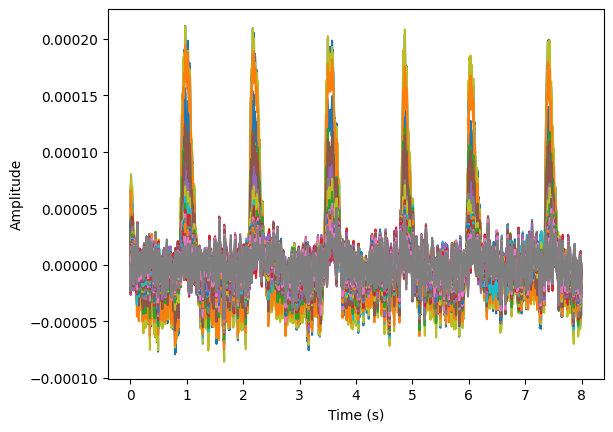

In [19]:
exclude_channels = [
    "target_X", "target_Z", "target_S", "HEOG_lpf", "VEOG_lpf", "REOG_lpf",
    "block", "eye-l", "eye-r", "eye-d", "eye-u", "eye-blink", "eye-fix",
    "eye-art", "label", "artifactclasses",
    "Fp1", "Fp2", "EOGmiddle", "EOGright", "EOGleft",
    "EOG-R-Top", "EOG-R-Side", "EOG-R-Bottom", "EOG-L-Top", "EOG-L-Side", "EOG-L-Bottom",
    "HEOG", "VEOG", "REOG", "EOGL1", "EOGL2", "EOGL3", "EOGR1", "EOGR2", "EOGR3"
]

epoch_data = converted_epochs[0].get_data()[0]  # First epoch (shape: n_channels x n_times)
times = converted_epochs[0].times

include_indices = [i for i, ch in enumerate(converted_epochs[0].ch_names) if ch not in exclude_channels]
filtered_data = epoch_data[include_indices, :]  # Exclude channels

plt.plot(times, filtered_data.T)  # Transpose for correct shape
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

...And after splitting!

58
140


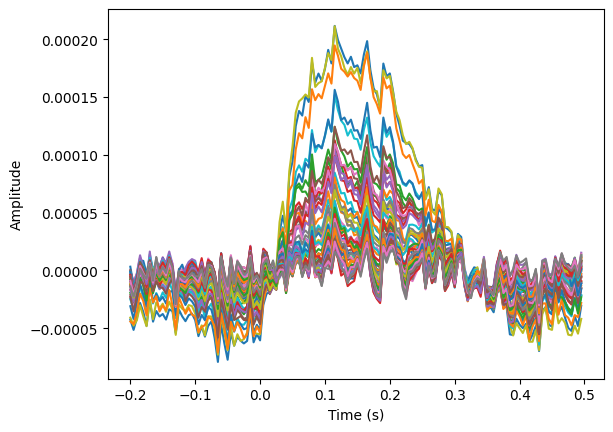

In [20]:
k = 0
while k < len(split_epochs):
    epoch_data = split_epochs[k].get_data()[0]  # First epoch (shape: n_channels x n_times)
    times = split_epochs[k].times

    include_indices = [i for i, ch in enumerate(split_epochs[0].ch_names) if ch not in exclude_channels]
    filtered_data = epoch_data[include_indices, :]  # Exclude channels

    print(len(filtered_data))
    print(len(times))

    plt.plot(times, filtered_data.T)  # Transpose for correct shape
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()
    k += 6

##Generating and saving topoplots
Each plot is saved as a png file in their respective categories; target (blinks), or negative data (everything else).

In [26]:
def save_topoplots(split_epochs, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    img_idx = 0

    for epochs in split_epochs:
        fixed_eeg_channels = [ch for ch in epochs.info["ch_names"] if ch not in exclude_channels]  # Ensure a fixed set

        for i in range(len(epochs)):
            tmp_plot = epochs.copy().pick_channels(fixed_eeg_channels)  # Avoid modifying the original object

            # Get the data for the current epoch (shape: n_channels, n_times)
            epoch_data = tmp_plot[i].get_data().squeeze()

            # Compute the mean across time for each channel
            mean_activity = np.mean(epoch_data, axis=1)  # Shape: (n_channels,)

            # Create an "Evoked" object with the averaged data (single artificial time point)
            evoked = mne.EvokedArray(mean_activity[:, np.newaxis], tmp_plot.info, tmin=0)

            # Generate the topomap plot
            fig = evoked.plot_topomap(times=0, ch_type="eeg", colorbar=False, outlines="head")

            # Save the figure as an image
            plot_filename = os.path.join(output_folder, f"{output_folder}_{img_idx}.png")
            fig.savefig(plot_filename)
            plt.close(fig)  # Close the figure to free memory

            img_idx += 1  # Increment the image index

            print(f"Saved topomap: {plot_filename}")


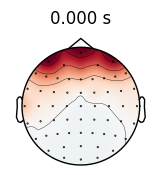

Saved topomap: blinks_data/blinks_data_0.png


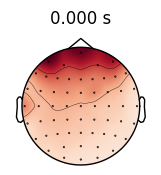

Saved topomap: blinks_data/blinks_data_1.png


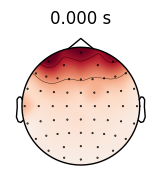

Saved topomap: blinks_data/blinks_data_2.png


KeyboardInterrupt: 

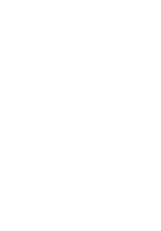

In [27]:
save_topoplots(split_epochs, "blinks_data")
save_topoplots(negative_epochs, "negative_data")

Notes:

Image maps may work as an alternative to Topoplots.

https://mne.tools/1.8/generated/mne.find_events.html